<b>Time Series</b>

an ordered sequence of values usually equally spaced over timeevery year, day, second or even every few microseconds like in the audio clip.

- Analyze anything that evolves over time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    plt.figure(figsize=(10, 6))
    plt.show()

Types

- Univariate: a singlie value at each time-step
![Alt text](explanation_images/univariate.png)

- Multivariate: multiple values at each time-step
![Alt text](explanation_images/multivariate.png)


<b>Applications:</b>

- Imputaion 
- Forcasting
- Anomoly Detection

<b>Common Patterns of time series</b>

- Trend: Drift Up or down
![Alt text](explanation_images/trend.png)

In [3]:
# Linear trend
def trend(time, slope=0):
    return slope * time

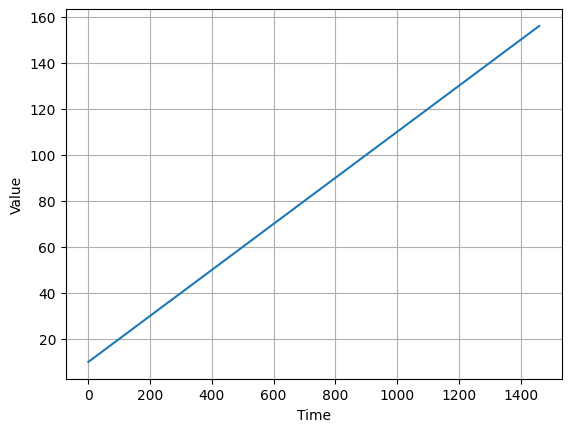

<Figure size 1000x600 with 0 Axes>

In [6]:
time = np.arange(4 * 365 + 1)
basline = 10
series = basline + trend(time, 0.1)

plot_series(time, series)

In [7]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [8]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

- Seasonality: patterns repeats at predictable seasons
    - peaks
    - troughs

![Alt text](explanation_images/Seasonality.png)


In [15]:
# creates a seasonal pattern
def seasonal_pattern(season_time):
    return np.where(season_time <0.4,
                    np.sin(season_time * 2 * np.pi),
                    1/np.exp(3 * season_time))

In [11]:
# reapets a seasonal pattern
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

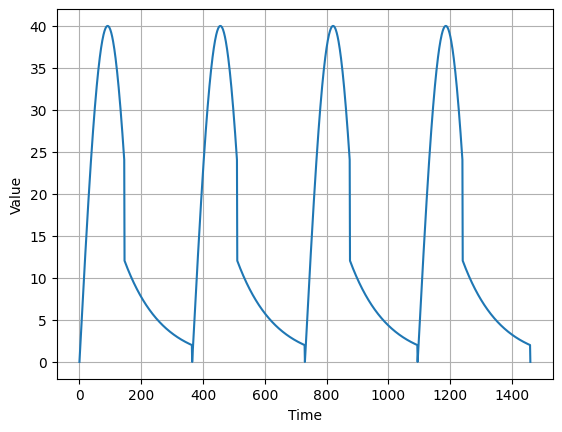

<Figure size 1000x600 with 0 Axes>

In [16]:
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plot_series(time, series)

- Trend & Seasonality
![Alt text](explanation_images/trend&seas.png)

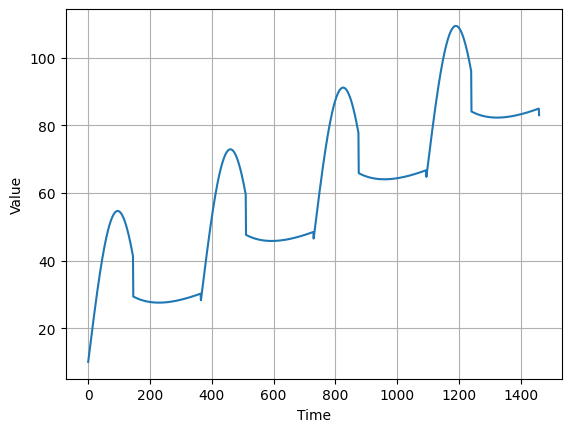

<Figure size 1000x600 with 0 Axes>

In [17]:
slope = 0.05
series = basline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
plot_series(time, series)

- White noise: Completely unpredictable, random numbers
![Alt text](explanation_images/whitenoise.png)

In [18]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)#every peice of boise is independant than the other
    return rnd.randn(len(time))* noise_level

But in real life there could be correlation between the noise themselves

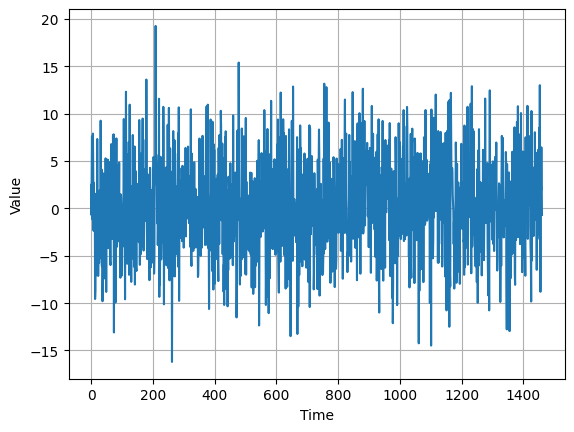

<Figure size 1000x600 with 0 Axes>

In [19]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)
plot_series(time, noise)

- Trend & Seasonality & Noise: thats realistic

![Alt text](explanation_images/allpatterns.png)


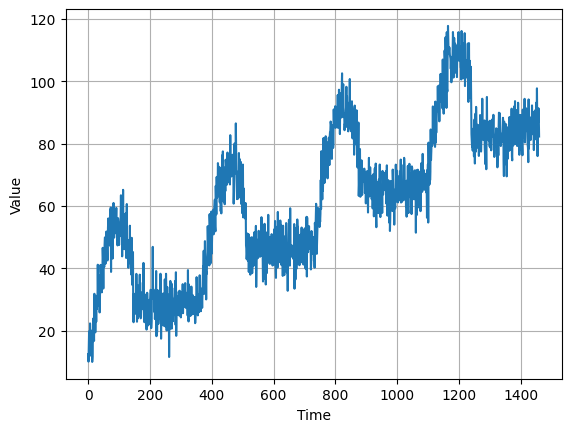

<Figure size 1000x600 with 0 Axes>

In [20]:
series += noise
plot_series(time, series)

<b>Forecasting</b>

<b>To mesure performancce:</b>

1- fixed partitioning

![Alt text](explanation_images/fixedPartitioning.png)


We also train on the test period (which is not usual in ML) because it contains the most recent is the one that is most useful info to predict the future.

2- Roll-forward Partitioning

![Alt text](explanation_images/rollForward.png)

it will require more training time, but it will mimick the 

In [21]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = time[split_time:]

<b>Naive Forescasting</b>

Take the last value and assume the next will be the same.

![Alt text](explanation_images/naiveForcasting.png)